# Лекция 6. Работа с файлами в операционной системе Linux средствами ассемблера (продолжение)

1. Копирование, перемещение, переименование файлов.
2. Усечения файлов.
3. Работа со ссылками.
4. Получение, изменение текущего каталога, cоздание, удаление каталогов, чтение содержимого каталога.
5. Узлы устройств. Специальные узлы устройств.

## 1. Копирование, перемещение, переименование файлов.

В Linux нет специального системного вызова для выполнения копирования файлов или каталогов. Вместо этого утилиты наподобие
cp выполняют эти операции вручную. 
Для копирования файла "a" в файл под названием "b" необходимо выполнить следующие действия.
1. Открыть файл "a" на чтение.
2. Открыть файл "b" на запись — создать его, если он не существует, или сократить до нулевой длины, если он есть.
3. Считать фрагмент содержимого "a" в память.
4. Записать этот фрагмент в "b".
5. Продолжать, пока все содержимое "a" не будет считано и переписано в "b".
6. Закрыть "a".
7. Закрыть "b".

В предложенной ниже программе (аналог **cp**) реализуется именно этот процесс. Файл, который нужно копировать, задается первым параметром командной строки, файл, куда нужно копировать - вторым параметром.

In [ ]:
format elf64
public _start

include 'func.asm'

section '.bss' writable

  buffer rb 100

section '.text' executable

_start:
  ;Считываем количество пааметров командной строки
   pop rcx
   cmp rcx, 3
   jl .l1

   ;открываем файл, который будем читать
   mov rdi,[rsp+8]
   mov rax, 2
   mov rsi, 0o
   syscall
   cmp rax, 0
   jl .l1
   ;Сохраняем дескриптор
   mov r8, rax

   ;открываем файл, в который будем копировать
   mov rdi,[rsp+16]
   mov rax, 2
   mov rsi, 577
   mov rdx, 777o
   syscall
   cmp rax, 0
   jl .l1
   ;Сохраняем дескриптор
   mov r9, rax

   ;Признак окончания чтения
   xor r10, r10
   .loop:
     mov rax, 0 ;номер системного вызова чтения
     mov rdi, r8
     mov rsi, buffer
     mov rdx, 100
     syscall
     cmp rax, 0
     jne .next
     inc r10
     .next:
       mov rdi, r9
       mov rdx, rax
       mov rax, 1
       mov rsi, buffer
       syscall
       cmp r10,0
       je .loop

   mov rdi, r8
   mov rax, 3
   syscall

   mov rdi, r9
   mov rax, 3
   syscall

.l1:
   call exit

Ниже представлен пример использования данной программы: происходит копирование системной утилиты **ls**, после чего скопированная версия (названная myls) работает как обычный **ls**:

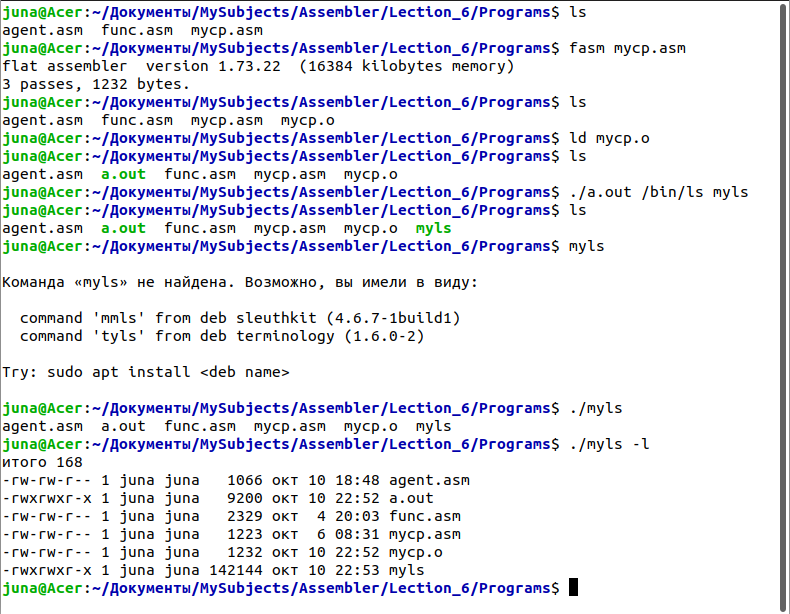

Если для копирования специального системного вызова не предусмотрено, то для перемещения файла такой вызов есть.

In [ ]:
#include <stdio.h>
int rename (const char *oldpath, const char *newpath);

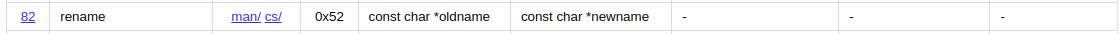

Успешный вызов rename() переименовывает путь oldpath в newpath. Содержимое файла и inode остаются теми же самыми. И oldpath, и newpath должны остаться в той же файловой системе (хотя Linux позволяет вам подмонтировать устройство в нескольких точках структуры каталогов, невозможно передвинуть файл с одной из точек монтирования на другую, несмотря на то что фактически обе точки находятся на одном устройстве); если это не так, вызов вернет ошибку. Утилиты наподобие mv обрабатывают этот случай копированием файла и удалением ссылки.

При успехе rename() возвращает 0, и путь к файлу oldpath меняется на newpath. В случае неудачи вызов возвращает -1, никак не влияя ни на oldpath, ни на newpath.

Легко понять, что переименование и перемещение файла - родственные действия. Переименование по сути  - это перемещение файла в этот же каталог с новым именем.

Ниже представлен пример с этим системным вызовом - программа перемещает(переименовывает) файл внутри файловой системы.

In [ ]:
format elf64

public _start

include 'func.asm'

section '.data' writable
  msg db 'Error',0x0a,0

section '.text' executable

_start:
  pop rcx
  cmp rcx, 3
  jl .l1
  mov rax, 82
  mov rdi, [rsp +8]
  mov rsi, [rsp+16]
  syscall

  cmp rax, 0
  je .l1

  mov rsi,msg
  call print_str

.l1:
   call exit

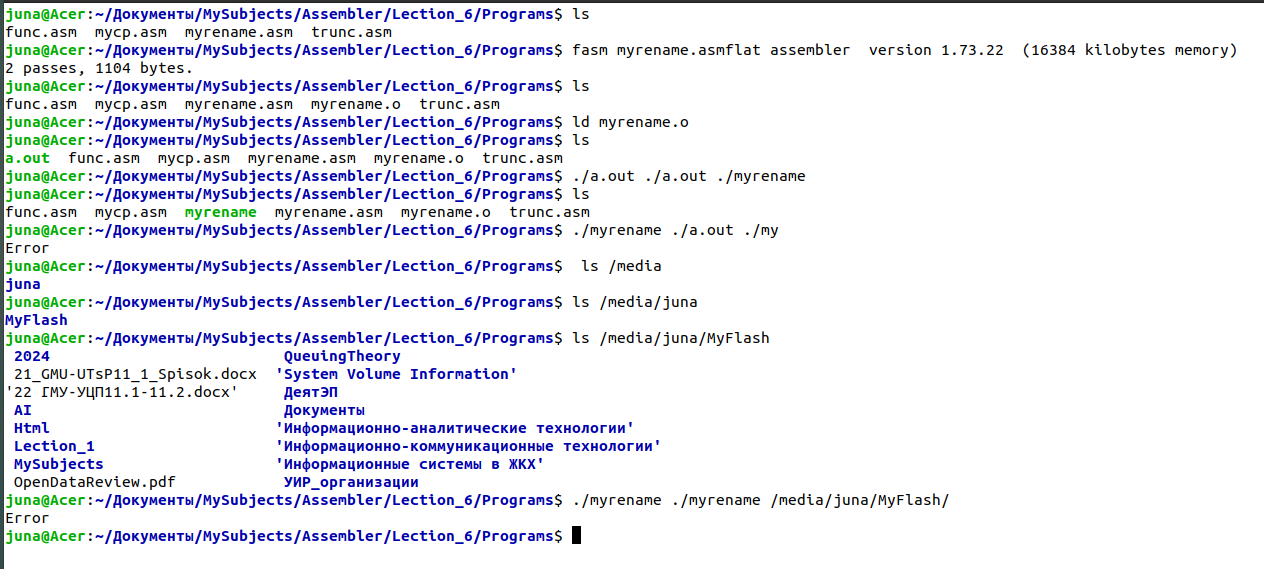

Из скриншота видно, что при попытке перемещения файла в другую файловую систему (флешка) происходит ошибка. Это естественно, поскольку при rename происходит лишь перепись связи имени файла и номера индексного дескриптора - из каталога источника она удаляется, в каталог приемник добавляется. При этом никакого физического перенесения файла не происходит. Однако номер индексного дескриптора уникален только внутри одной файловой системы. Поэтому при перенесении файла в другую файловую систему без физического перенесения не обойтить - файл должен быть скопирован в новое место и стерт со старого.

## 2. Усечения файлов. 

В Linux существуют два системных вызова для принудительного изменения длины файлов. И хотя они называются "усечением файла" их можно использовать как в сторону уменьшения объема, так и в сторону его увеличения.

In [ ]:
#include <unistd.h>
#include <sys/types.h>
int ftruncate (int fd, off_t len);

int truncate (const char *path, off_t len);

Оба системных вызова выполняют усечение заданного файла до длины, указанной в len. Системный вызов ftruncate() оперирует файловым дескриптором fd, который должен быть открыт для записи. Системный вызов truncate() оперирует именем файла, указанным в path, причем этот файл должен быть пригоден для записи. Оба вызова при успешном выполнении возвращают 0. При ошибке оба вызова возвращают -1.

Все данные, прежде находившиеся после len, удаляются и становятся недоступны для запросов на считывание.

Если len оказывается больше размера файла, то дополнительные байты заполняются нулями. Ни при одной из этих операций файловая позиция не обновляется.

Рассмотрим пример увеличения размера файла в два раза. Для этого прочитаем имя файла из командной строки, получим размер файла из индексного дескриптора этого файла, после чего выполним удвоение длины и "усечение" файла до этой длины. 

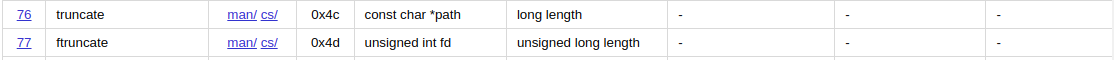

In [ ]:
format elf64

public _start

include 'func.asm'

section '.bss' writable

Struc stat
{
  .st_dev dq ?
  .st_ino dq ?
  .st_nlink dq ?
  .st_mode dd ?
  .st_uid dd ?
  .st_gid dd ?
  .st_rdev dq ?
  .st_res_1 dd ?
  .st_size dq ?
  .st_blksize dq ?
  .st_blocks dq ?
  .st_atime dq ?
  .st_atime_nsec dq ?
  .st_mtime dq ?
  .st_mtime_nsec dq ?
  .st_ctime dq ?
  .st_ctime_nsec dq ?
}

buffer rb 200
mystat stat

section '.text' executable

_start:
     pop rcx 
     cmp rcx, 1 
     je .l1

     mov rdi,[rsp+8] 
     mov rax, 2 
     mov rsi, 2o ;права на чтение и запись 
     syscall 
     cmp rax, 0 
     jl .l1 

    mov r8, rax ;сохраняем файловый дескриптор
    mov rax, 4
    mov rsi, mystat
    syscall

    ;;считываем размер файла
    xor rax, rax
    mov rax, [mystat.st_size]
    
    ;;удваиваем размер
    xor rdx,rdx
    mov rcx,2
    mul rcx
    
    mov r9,rax

   ;;выполняем усечение
   mov rax, 77
   mov rdi, r8
   mov rsi, r9
   syscall
   
   ;;Системный вызов close
   mov rdi, r8
   mov rax, 3
   syscall
   

.l1:
    call exit


Ниже показан пример работы программы. Для этого взята программа, которая по символу печатает его код (рассматривали ранее). Как видно, после удвоения размера программы, она продолжает успешно работать.

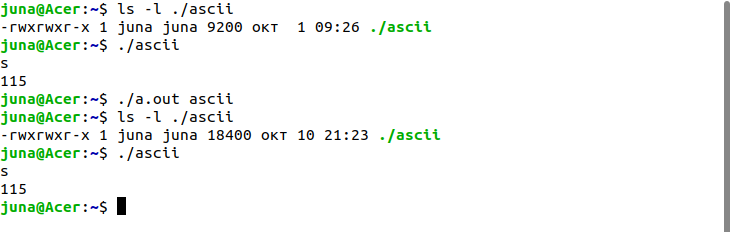

## 3. Работа со ссылками.

Cвязь между именем и номером inode в каталоге называется **ссылкой**. Исходя из этого простого определения ссылка представляет собой всего лишь имя в списке (каталоге), которое указывает на inode, и, таким образом, может существовать несколько ссылок на один и тот же inode.

В пределах одной файловой системы к одному и тому же файлу может относиться много ссылок. Единственное ограничение касается размера целочисленного типа данных, используемого для хранения ссылок. Среди всех различных ссылок ни одна не может считаться «основной» или «оригинальной»: статус всех ссылок одинаков и все они указывают на один файл. Такие типы ссылок мы называем **жесткими ссылками**. Файлы могут не иметь ни одной, иметь одну или много ссылок. 

Большинство файлов имеют количество ссылок, равное 1. Это значит, что на них ссылается единственная запись в каталоге,
но некоторые файлы имеют две ссылки или даже больше. Файлы, количество ссылок на которые равно 0, не имеют соответствующих записей каталога в системе.

Когда количество ссылок на файл равно 0, файл помечается как свободный, а его дисковые блоки становятся свободными для использования (Поиск файлов с количеством ссылок, равным 0, но с блоками, помеченными как занятые, — основная задача fsck, утилиты контроля над файловой системой. Подобное условие может возникать, когда файл удаляется, но остается открытым, и в системе происходит аварийный сбой до закрытия файла. Ядро не имеет возможности пометить блоки
файловой системы как свободные для использования, из-за чего и возникают несоответствия. Протоколирование файловой системы устраняет этот тип ошибок.)

Такой файл, однако, остается в файловой системе, если он открыт у какого-либо процесса. После того как все процессы закрыли этот файл, он удаляется.

Ядро Linux реализует этот подход, используя счетчик ссылок и **счетчик использований**. Счетчик использований — это общее количество экземляров, где открыт данный файл. **Файл не удаляется из файловой системы, пока количество как ссылок, так и использований не станет равным 0.**

Рассмотрим создание жестких ссылок на файл и удаление этих жестких ссылок на практике.

Для создания жестких ссылок используется системный вызов **link**.

In [ ]:
#include <unistd.h>
int link (const char *oldpath, const char *newpath);

Успешный вызов **link()** создает новую ссылку по пути newpath для существующего файла oldpath, а затем возвращает 0. После выполнения и oldpath, и newpath ссылаются на один и тот же файл - фактически нельзя сказать, какой из этих путей является «исходным». В случае сбоя вызов возвращает -1.

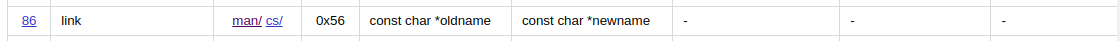

Для удаления жестких ссылок используется системный вызов **unlink**.

In [ ]:
#include <unistd.h>
int unlink (const char *pathname);

Успешный вызов unlink() удаляет pathname из файловой системы и возвращает 0. Если этот путь был последней ссылкой на файл, файл удаляется из системы. Если, однако, файл открыт в каком-либо процессе, ядро не будет удалять файл из файловой
системы, пока процесс не закроет этот файл. Если же этот файл не открыт ни в одном процессе, он удаляется.

Если pathname ведет к символической ссылке, удаляется сама ссылка, а не ее цель. Если pathname ссылается на другой тип специального файла, например устройство, конвейер FIFO или сокет, этот файл удаляется из файловой системы, но процессы, у которых он открыт, могут продолжать его использовать.

В случае ошибки unlink() возвращает -1.

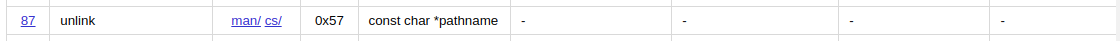

Ниже рассмотрен пример создания и удаления жесткой ссылки. Программа принимает несколько параметров: если первый параматр равен 1, то программа добавляет на файл, указанный вторым параметром, жесткую ссылку, указанную третьим параметром. Если первый параметр равен нулю, то программа пытается удалить жесткую ссылку, указанную вторым параметром. 

In [ ]:
format elf64

public _start

include 'func.asm'

section '.data' writable

msg db 'error', 0x0a, 0

section '.text' executable

_start:

  pop rcx

  ;;Если два параметра
  cmp rcx, 3
  jne .l1
  mov rax, [rsp+8]
  cmp byte [rax], '0'
  jne .l2
  mov rax, 87
  mov rdi, [rsp+16]
  syscall
  cmp rax, 0
  jl .l3
  jmp .l2

  ;;Если три параметра
.l1:
  cmp rcx, 4
  jne .l2
  mov rax, [rsp+8]
  cmp byte [rax], '1'
  jne .l2
  mov rax, 86
  mov rdi, [rsp+16]
  mov rsi,[rsp+24]
  syscall
  cmp rax, 0
  jl .l3
  jmp .l2
.l3:
  mov rsi,msg
  call print_str

.l2:
   call exit

Ниже приведен пример использования данной программы. Вначале проводим компиляцию и линковку. Полученный исполняемый файл запускаем на добавление жесткой ссылки на сам себя с названием 'xxx'. После этого, используя **ls**, получаем уже 2 жесткие ссылки для файлов ./a.out и xxx. Затем удаляем одну жесткую ссылку на файл a.out - в результате он сам удаляется, а количество жестких ссылок у xxx становится равно 1. Наконец, мы удаляем жесткую ссылку на сам xxx, после чего он сам окончательно удаляется.

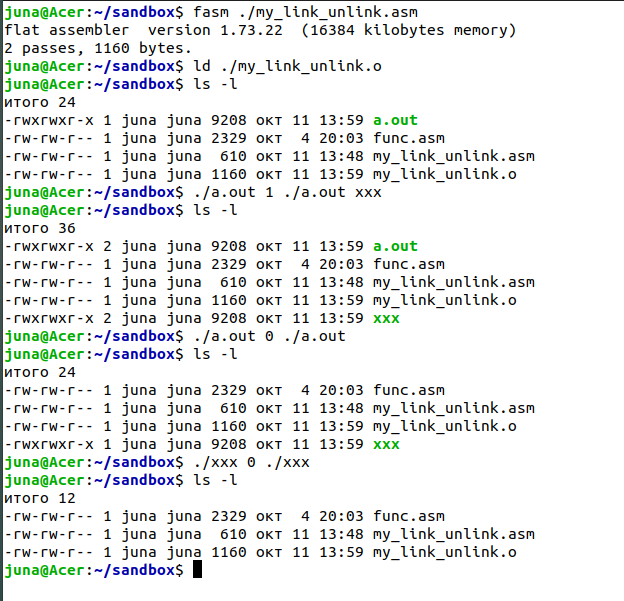

Другой тип ссылки, **символическая ссылка**, является не маршрутизатором файловой системы, а более высокоуровневым указателем, который интерпретируется во время выполнения. Такие ссылки могут охватывать разные файловые системы.

Символические ссылки, еще известные как симссылки и мягкие ссылки, сходны с жесткими ссылками тем, что они также указывают на файлы в файловой системе. Однако символические ссылки представляют собой не просто дополнительную запись каталога, но и специальный тип файла. Этот специальный файл содержит путь к другому файлу, называемому целью символической ссылки. Во время выполнения ядро на лету заменяет путь к файлу символической ссылки путем к цели символической ссылки.

Символическая ссылка может быть относительной или абсолютной.

Символические ссылки могут указывать на файл, который существует (обычное явление) или не существует. Последний тип ссылки называется **повисшей символической ссылкой**.

Символическая ссылка даже может указывать на другую символическую ссылку. Таким образом можно создавать петли.

Для создания символической ссылки используется системный вызов **symlink**, который концептуально повторяет **link**:


In [ ]:
#include <unistd.h>
int symlink (const char *oldpath, const char *newpath);

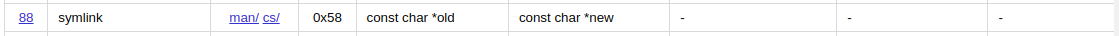

Успешный вызов symlink() создает символическую ссылку newpath, указывающую на цель oldpath, а затем возвращает 0. В случае ошибки symlink() возвращает -1.

Символическая ссылка удаляется с помощью того же системного вызова **unlink**. Только в случае символической ссылки удалется она сама, а не файл-цель.

Также существует системный вызов, который позволяет посмотреть, на что ссылается символическая ссылка. Это вызов **readlink**:

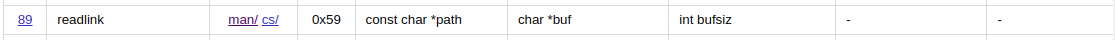

In [ ]:
#include <unistd.h>

ssize_t readlink(const char *restrict pathname, char *restrict buf, size_t bufsiz);

**readlink ()** помещает содержимое символической ссылки pathname в буфер buf, который имеет размер bufsiz.   

При чтении завершающий нулевой байт к buf не добавляется. Если bufsiz меньше содержимого, то оно будет обрезано до количества символов bufsize.

Ниже представлен пример работы с символическими ссылками, как модификация предыдущей программы.

In [ ]:
format elf64

public _start

include 'func.asm'

len = 1000

section '.data' writable

msg db 'error', 0x0a, 0

section '.bss' writeable
 
buffer rb len

section '.text' executable

_start:

  pop rcx

  ;;Если два параметра
  cmp rcx, 3
  jne .l1
  mov rax, [rsp+8]
  cmp byte [rax], '0'
  jne .l4
  mov rax, 87
  mov rdi, [rsp+16]
  syscall
  cmp rax, 0
  jl .l3
  jmp .l2

.l4:
  cmp byte [rax], '2'
  jne .l1
  mov rax, 89
  mov rdi, [rsp+16]
  mov rsi,buffer
  mov rdx, len
  syscall
  mov [buffer + rax], 0
  call print_str
  call new_line
  jmp .l2

  ;;Если три параметра
.l1:
  cmp rcx, 4
  jne .l2
  mov rax, [rsp+8]
  cmp byte [rax], '1'
  jne .l2
  mov rax, 88
  mov rdi, [rsp+16]
  mov rsi,[rsp+24]
  syscall
  cmp rax, 0
  jl .l3
  jmp .l2
.l3:
  mov rsi,msg
  call print_str
  jmp .l2


.l2:
   call exit

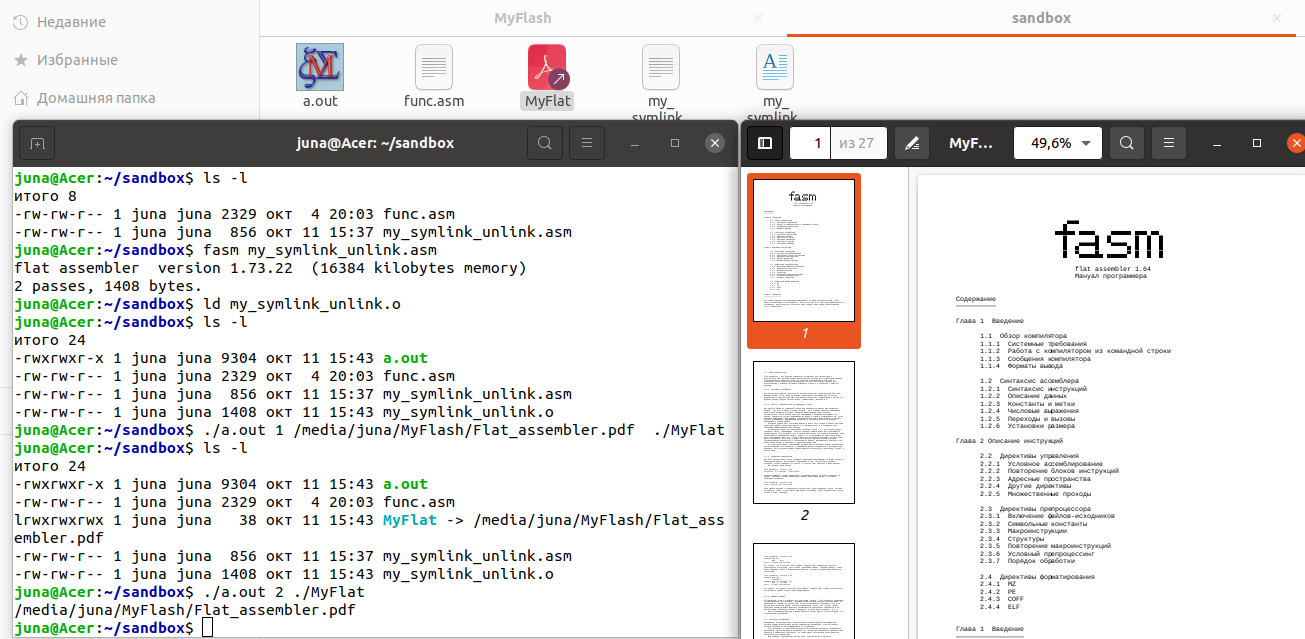

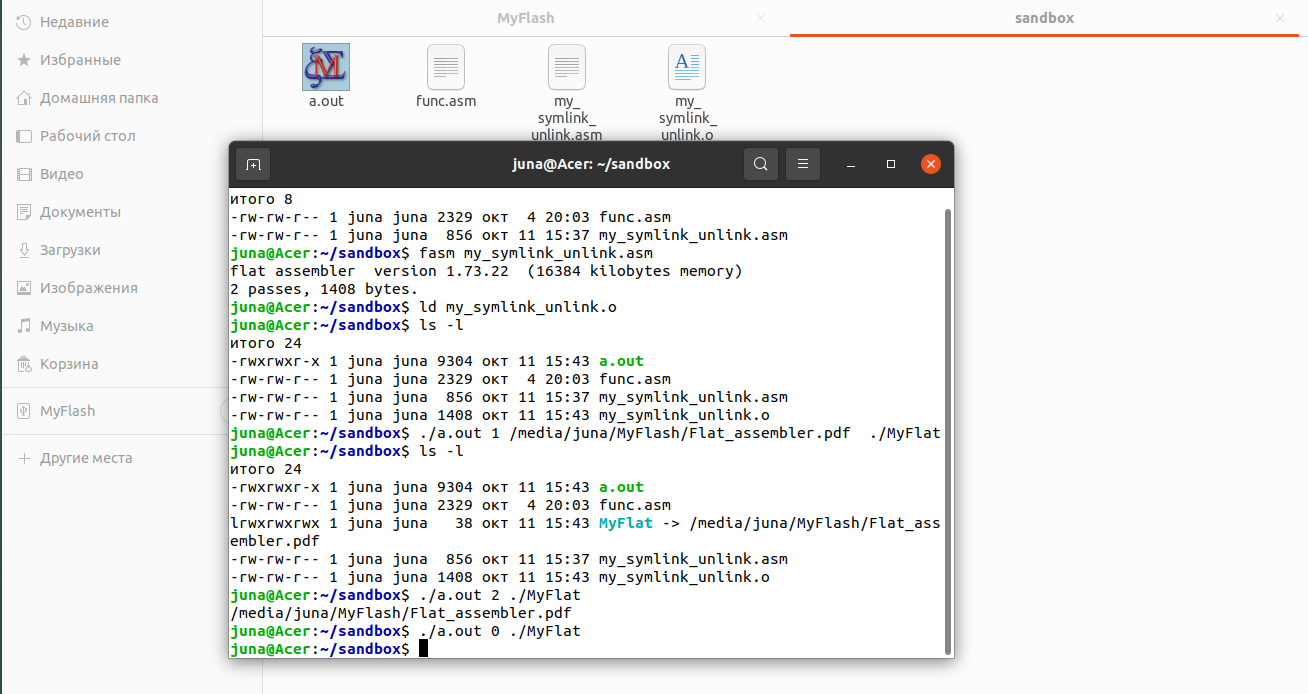

Из приведенных скриншотов видно, что после компиляции и линковки программы ее можно запускать с тремя значениями первого параметра:
- 0 - удаляет символическую ссылку (вызов **unlink**)
- 1 - создает символическую ссылку (вызов **symlink**)
- 2 - выводит информацию, на что ссылается ссылка (вызов **readlink**)

В примере видно, что мы создает символическую ссылку на файл флешки "Flat_assembler.pdf", саму ссылку называем MyFlat, также в дальнейшем печатается информация о ссылке, после чего ссылка удаляется.

Интересно отметить, что если вынуть флеш носитель и оставить ссылку, то после попытки ее запуска операционная система помечает, что она битая:

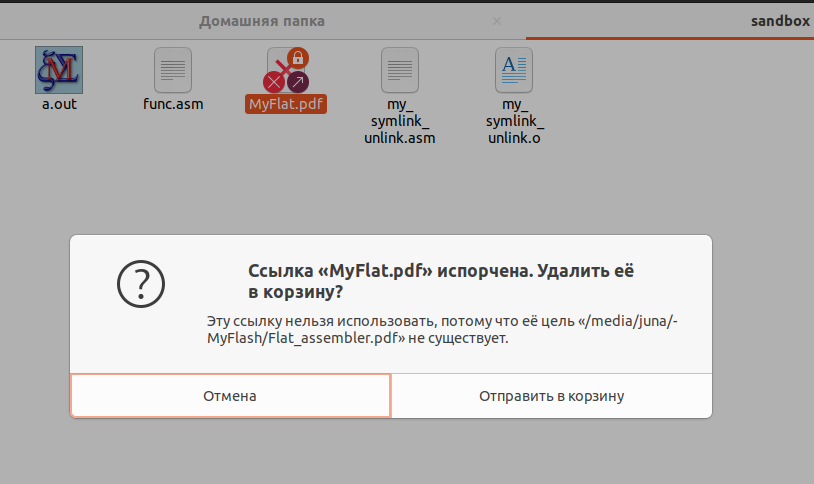

## 4. Получение, изменение текущего каталога, cоздание, удаление каталогов, чтение содержимого каталога.

Каталог - это файл, который содержит список названий файлов, с каждым из которых связан номер индексного дескриптора. Каждое имя называется записью в каталоге, а каждая связь имени и номера индексного дескриптора именуется ссылкой. Содержимое каталога, которое пользователь видит в результате выполнения команды ls, является списком всех имен файлов в этом каталоге.

Когда пользователь открывает файл в данном каталоге, ядро ищет имя файла в списке данной директории, чтобы определить соответствующий номер индексного дескриптора. Затем ядро передает этот номер в файловую систему, которая использует его, чтобы определить физическое размещение файла на устройстве.

Каталоги могут также содержать другие каталоги. **Подкаталогом** называется каталог, находящийся внутри другого каталога. Согласно этому определению все каталоги являются подкаталогами каких-либо родительских каталогов, за исключением каталога в корне дерева файловой системы, /. Этот каталог так и называется **корневым каталогом**.

Путь к файлу состоит из имени файла вместе с одним или несколькими его родительскими каталогами. **Абсолютным путем к файлу** называется путь, который начинается с корневого каталога, например /home/student/flat.pdf. 

**Относительным путем** называется путь, который не начинается с корневого каталога, к примеру assembler/func.asm. Чтобы использовать такой путь, операционная система должна знать каталог, к которому он относится. Текущий рабочий каталог используется в качестве стартовой точки.

Названия файла и каталога могут содержать любые символы, кроме /, разделяющих каталоги в записи пути к файлу, и пустого значения (null), завершающего путь к файлу. Тем не менее принято ограничивать использование символов в записях пути: как правило, используются только допустимые печатные символы из текущих языковых настроек или даже только символы ASCII. Однако поскольку ни ядро, ни библиотеки С не предписывают такую практику, разработчики приложений самостоятельно принимают решение о допустимости использования тех или иных символов.

В старых системах UNIX длина имени файла ограничивалась 14 символами. Сегодня все современные системы UNIX позволяют использовать для каждого файла по меньшей мере 255 байт. (речь идет не о 255 символах, а о 255 байтах. Многобайтовые символы, разумеется, займут больше одного байта из этих 255.) Многие файловые системы под Linux позволяют использование даже более длинных имен файлов.

Каждый каталог содержит два особых каталога: . и .. (они называются «точка» и «точка-точка»). Точка — ссылка на сам каталог. Точка-точка — ссылка на родительский каталог для данного каталога. 

Каждый процесс имеет текущий каталог, который наследует непосредственно от своего родительского процесса. Этот каталог называется **текущим рабочим каталогом процесса**. 

Текущая рабочая директория является начальной точкой, из которой ядро прокладывает относительные пути к файлам. 

Для получения текущего рабочего каталога используется системный вызов **getcwd()**.

In [ ]:
#include <unistd.h>
char * getcwd (char *buf, size_t size);

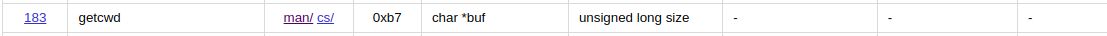

Успешный вызов **getcwd()** копирует текущий рабочий каталог как абсолютный путь в буфер, указанный как buf и имеющий длину size байт, и возвращает указатель к buf. В случае ошибки вызов возвращает NULL.

В Linux есть два системных вызова для изменения текущего рабочего каталога: один, который устанавливает путь к каталогу, и другой, который прописывает файловый дескриптор, представляющий открытый каталог.

In [ ]:
#include <unistd.h>
int chdir (const char *path);
int fchdir (int fd);

Вызов **chdir()** изменяет текущий рабочий каталог согласно пути, указанному в path, который может быть абсолютным или относительным. 

Аналогично вызов **fchdir()** изменяет текущий рабочий каталог согласно пути, указанному через файловый дескриптор fd, который должен быть открыт для этого каталога. В случае успеха оба вызова возвращают 0, при неудаче возвращается -1.

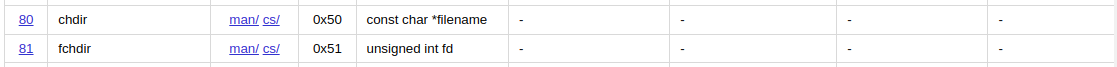

Иногда требуется сохранить текущий каталог, чтобы потом вернуться в него. Это можно сделать с помощью системного вызова **getswd()**:

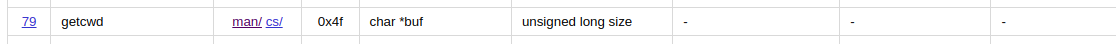

In [ ]:
#include <unistd.h>

char *getcwd(char buf[.size], size_t size);

Эта функция возвращают строку с нулевым символом в конце, содержащую абсолютный путь, который является текущим рабочим каталогом
Функция **getcwd ()** копирует абсолютный путь текущего рабочего каталога в массиве, на который указывает buf. Если длина абсолютного пути текущего рабочего каталога, включая завершающий нулевой байт, превышает размер size в байтах, возвращается NULL.

Однако лучше сначала открыть вызовом open() текущий каталог, а затем возвращаться в него с помощью fchdir(). Это быстрее, так как ядро не сохраняет в памяти полный путь к текущему рабочему каталогу; хранится только структура inode.


Для создания каталогов Linux предоставляет системный вызов:

In [ ]:
#include <sys/stat.h>
#include <sys/types.h>
int mkdir (const char *path, mode_t mode);

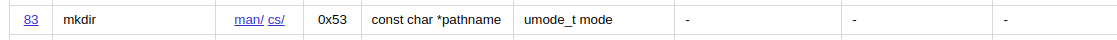

При создании каталога с помощью **mkdir** должны быть указаны права доступа, как и в случае обычного файла. Надо всегда понимать, от чьего имени
запускается программа и какие имеются права у данного пользователя.

Есть очень удобная системная функция с номером 21 и именем **access**. С помощью этой функции можно узнать есть или нет у данной программы (запущенной от имени пользователя) те или иные права на файл или каталог.

Для удаления каталогов используется системный вызов **rmdir**:

In [ ]:
#include <unistd.h>
int rmdir (const char *path);

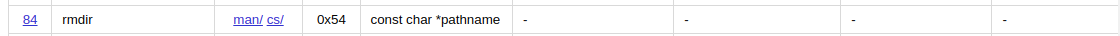

В случае успеха rmdir() удаляет path из файловой системы и возвращает 0. В случае ошибки rmdir() возвращает -1. **Каталог, указанный через path, должен быть пустым.**

Для чтения содержимого каталога используется системный вызов **getdents()**.

In [ ]:
int getdents (unsigned int fd, struct dirent *dirp, unsigned int count);

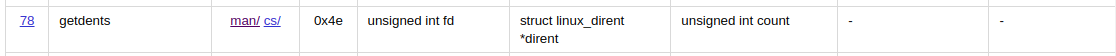

Системный вызов **getdents ()** считывает несколько структур linux_dirent из каталога, на который ссылается открытый файловый дескриптор fd, в буфер, на который указывает dirp . Аргумент count указывает размер этого буфера. Функция возвращает количество считанных байтов.

Каждая структура linux_direct имеет на С следующий вид:

In [ ]:
 struct linux_dirent {
   unsigned long  d_ino;     
   unsigned long  d_off;     
   unsigned short d_reclen;  
   char           d_name[];  
  /*
     char           pad;       
     char           d_type;    
                                         
  */
}

**d_ino** - номер индексного дескриптора (8 байт).   

**d_off** - специфичное для файловой системы значение, не имеющее особого значения для пространства пользователя, хотя в старых файловых системах оно использовалось как расстояние от начала каталога до начала следующего linux_dirent. (8 байт)
        
**d_reclen** - размер всего linux_dirent. (2 байта)   

**d_name** - имя файла с завершающим нулем. (произвольное количество, признак завершения - окончание нулем)

**d_type** - байт в конце структуры, указывающий тип файла. 

d_type содержит одно из следующих значений (определенных в <dirent.h> ): 
- DT_BLK (значение 6) блочное устройство. 
- DT_CHR (значение 2) символьное устройство. 
- DT_DIR (значение 4) каталог. 
- DT_FIFO (значение 1) именованный канал (FIFO). 
- DT_LNK (значение 10) символическая ссылка. 
- DT_REG (значение 8) обычный файл. 
- DT_SOCK (значение 12) сокет домена UNIX.  
- DT_UNKNOWN неизвестный тип

Поскольку размеры структуры заранее не определены, при чтении по count байт мы может прочитать только часть структуры. Чтение следует заканчивать, когда количество прочитанных байт окажется равным нулю. Можно было бы читать струтуры за раз, лучше сначала считывать по 8 (d_ino)+8(d_off)+2(d_reclen)=18 байт (это количество всегда строго нормировано) - тогда последние два байта указывают длину всей структуры и чтобы дочитать остаток, нужно прочитать  (d_reclen - 18) байт. Однако минимальная единица чтения с блочного устройства равна одному сектору (один сектор чаще всего 512 байт), а наименьшим логически адресуемым элементом файловой системы является блок, который является степенью двойки от размера сектора.

Можно, кстати, заметить, что последние два поля структуры закоментированы. Это не потому, что их нет, а потому, что их местоположение зависит от длины имени в d_name, но в любом случае - последний байт в структуре linux-dirent - это тип файла.

Важно заметить, чтобы открыть каталог на чтение прежде нужно воспользоваться системным вызовом **open**, при этом нужно сформировать флаг:
O_RDONLY | O_DIRECTORY, что соответствует $$00000000_8\| 00200000_8 = 65536_{10}$$

Ниже приведен пример программы, в которой для заданного каталога выводится его содержимое: для каждого файла печатается его индексный дескриптор, название файла и его тип.

In [ ]:
format elf64
public _start

include 'func.asm'

len = 1024

section '.data' writable

  DT_BLK    db " block device ",0x0a, 0               ;(значение 6) блочное устройство.
  DT_CHR    db " symbolic device ",0x0a, 0            ;(значение 2) символьное устройство.
  DT_DIR    db " directory ",0x0a, 0                  ;(значение 4) каталог.
  DT_FIFO   db " fifo ",0x0a, 0                       ;(значение 1) именованный канал (FIFO).
  DT_LNK    db " symbolic link ",0x0a, 0              ;(значение 10) символическая ссылка.
  DT_REG    db " file ",0x0a, 0                       ;(значение 8) обычный файл.
  DT_SOCK   db " socket ",0x0a, 0                     ;(значение 12) сокет домена UNIX.
  DT_UNKNOWN   db "unknown device",0x0a, 0            ;неизвестный тип
  space db "  "

section '.bss' writable

  buffer rb len
  place rb len

section '.text' executable

_start:
    pop rcx
    cmp rcx, 2
    jne .l1

   ;;Открываем каталог на чтение
   mov rax, 2
   mov rdi, [rsp+8]
   mov rsi, 65536
   syscall
   cmp rax, 0
   jl .l1
   
   ;Сохраняем файловый дескриптор
   mov r8, rax

 .loop:
   
   ;;Читаем с винчестера len байт
   mov rax, 78
   mov rdi, r8
   mov rsi, buffer
   mov rdx, len
   syscall
   cmp rax, 0
   jle .l2
   mov r10, rax
   
   ;;текущая позиция в структуре
   xor rdx, rdx
   
   .loop2:
   ;;Печатаем d_ino
   mov rax, qword [buffer+rdx]
   cmp rax, 0
   je .loop	
   mov rsi, place
   call number_str
   call print_str
   mov rsi, space
   call print_str
   
   ;вычисляем размер структуры в r9
   xor r9,r9
   mov r9W, word [buffer+16+rdx]
   mov rax, r9
   mov rsi, place
   call number_str
   call print_str
   mov rsi, space
   call print_str

   ;печатаем имя файла
   mov rsi, buffer
   add rsi, 18
   add rsi, rdx
   call print_str

   mov al,byte[buffer + r9-1+rdx]
   call type_file
   
   add rdx, r9
   cmp rdx, r10
   jl .loop2

 jmp .loop

  ;;Закрываем чтение из каталога
.l2:   
   mov rax, 3
   mov rdi, r8
   syscall


.l1:
  call exit


;;input rax - number of file
;;output - print type of file
type_file:
 
   push rsi
   
   cmp rax, 1
   jne .l1
   mov rsi, DT_FIFO
   call print_str
   pop rsi
   ret
.l1:
   cmp rax, 2
   jne .l2
   mov rsi, DT_CHR
   call print_str
   pop rsi
   ret
.l2:
   cmp rax, 4
   jne .l3
   mov rsi, DT_DIR
   call print_str
   pop rsi
   ret
.l3:
   cmp rax, 6
   jne .l4
   mov rsi, DT_BLK
   call print_str
   pop rsi
   ret
.l4:
   cmp rax, 8
   jne .l5
   mov rsi, DT_REG
   call print_str
   pop rsi
   ret
.l5:
   cmp rax, 10
   jne .l6
   mov rsi, DT_LNK 
   call print_str
   pop rsi
   ret
.l6:
   cmp rax, 12
   jne .l7
   mov rsi, DT_SOCK 
   call print_str
   pop rsi
   ret
.l7:
   mov rsi, DT_UNKNOWN
   call print_str
   pop rsi
   ret

## 5. Узлы устройтсв. Специальные узлы устройств.

**Узлами устройств** называются специальные файлы, позволяющие приложениям взаимодействовать с драйверами устройств. 

Когда приложение выполняет обычный ввод-вывод — открытие, закрытие, чтение, запись и т. д. — на узле устройства, ядро не обрабатывает эти запросы как обычный ввод-вывод файлов. Вместо этого ядро отправляет эти запросы драйверу устройства. Драйвер обрабатывает операцию ввода-вывода и возвращает пользователю результат. 

Узлы устройства обеспечивают абстрагирование устройств, благодаря чему от приложения не требуется знания специфики устройства или владения специальными интерфейсами.

Узлы устройств — стандартный механизм для обеспечения доступа к аппаратному обеспечению в системах UNIX. 

**Каждому узлу устройства назначаются две числовые величины, называемые старшим номером и младшим номером**. Эти номера связаны со специальным драйвером устройства, открытым в ядре. 

Если узел устройства не имеет старших и младших номеров, соответствующих драйверу устройства в ядре, что иногда может произойти по определенным причинам, то запрос open() на этом устройстве вернет -1. Мы говорим, что этот узел устройства представляет несуществующее устройство.


**Специальные узлы устройств**

Несколько узлов устройств представлены во всех системах Linux. Эти узлы являются частью среды разработки Linux.

**Фиктивное устройство**

У фиктивного устройства старший номер равен 1, а младший равен 3. Оно находится в **/dev/null**. Файлом устройства должен владеть пользователь root, но он доступен для чтения и записи всем пользователям. Ядро бесшумно удаляет все запросы на запись в устройство. Все запросы на чтение файла возвращают EOF (end-of-file, то есть окончание файла).

**Нулевое устройство**

Нулевое устройство находится в **/dev/zero** и имеет старший номер 1, а младший — 5. Аналогично фиктивному устройству ядро бесшумно отклоняет запросы на запись к нулевому устройству. Чтение с устройства возвращает бесконечный поток пустых байтов.

**Полное устройство**

Полное устройство со старшим номером 1 и младшим 7 находится в **dev/full**. Как и в случае с нулевым, запросы на чтение возвращают нулевые символы (\0). Запросы на запись всегда возвращают ошибку ENOSPC, означающую, что вызываемое устройство переполнено.

Все эти устройства созданы с различными целями. Они полезны для проверки, как приложение обрабатывает сложные и проблемные случаи — например, заполнение файловой системы. Нулевое и фиктивное устройства игнорируют запись, поэтому они также предоставляют способ обойти нежелательный ввод-вывод, не создающий дополнительной нагрузки.


**Генератор случайных чисел**

Генераторы случайных чисел ядра находятся в **/dev/random** и **/dev/urandom**.

Их старшие номера равны 1, а младшие — 8 и 9 соответственно.

Генератор случайных чисел ядра собирает шум с драйверов устройств и других источников, а ядро собирает его и необратимо хеширует. 

Полученный результат сохраняется в пуле энтропии. 

Чтение /dev/random возвращает энтропию из этого пула. Результаты можно использовать в качестве начальных чисел в генераторах случайных чисел для генерирования ключей и других задач, которые требуют криптографически надежной энтропии.

Теоретически злоумышленник, который способен получить достаточно данных из энтропического пула и успешно взломать необратимый хеш, мог бы получить сведения о состоянии остальной части энтропического пула. Хотя такая атака
в настоящее время является лишь теоретической возможностью — пока не известно ни об одном подобном случае, — ядро учитывает эту вероятность и уменьшает оценку объема энтропии при каждом запросе на запись. 

Если оценка достигает нуля, считывание блокируется, пока система не сгенерирует дополнительную энтропию и оценка объема энтропии не достигнет значения, достаточного для удовлетворения запроса на чтение.

Устройство /dev/urandom не обладает таким свойством; чтение с него завершается успешно, даже если оценка количества энтропии, сделанная ядром, недостаточна для завершения запроса. Даже самые защищенные приложения — например, генератор ключей для защиты обмена данными в GNU Privacy Guard — требуют высокой криптографической надежности энтропии, поэтому большинство приложений должны использовать /dev/urandom, а не /dev/random. 

Операция чтения из последнего может заблокироваться на весьма продолжительное время, если не будет активности ввода-вывода, способной заполнить энтропический пул ядра. Эта ситуация нередко случается на бездисковых серверах с удаленной настройкой.

Ниже представлена небольшая программа, позволяющая получать одно случайное число при каждом запуске.

In [ ]:
format elf64
public _start

include 'func.asm'


section '.data' writable

f  db "/dev/urandom",0

section '.bss' writable

  number rq 1
  place rb 100

section '.text' executable

_start:
   mov rdi, f
   mov rax, 2 
   mov rsi, 0o
   syscall 
   cmp rax, 0 
   jl .l1 
   mov r8, rax

   mov rax, 0 ;
   mov rdi, r8
   mov rsi, number
   mov rdx, 1
   syscall
   
   mov rax, [number]
   mov rsi, place
   call number_str
   call print_str
   call new_line
   
   mov rax, 3
   mov rdi, r8
   syscall


.l1:
  call exit